In [6]:
# 해당 라인을 엄청 많이 실행시키고 평균 실행 시간을 계산해줌
%timeit a = 1

KeyboardInterrupt: 

# Preparing the data

In [30]:
import json
import calendar
import random
from datetime import date, timedelta
# faker : fake 데이터 만드는 라이브러리 
import faker
import numpy as np
from pandas import DataFrame
from delorean import parse
import pandas as pd
# make the graphs nicer - but deprecated );
# pd.set_option('display.mpl_style', 'default')

In [31]:
fake = faker.Faker()
usernames = set()
usernames_no = 100
# populate the set with 100 unique usernames
while len(usernames) < usernames_no:
    usernames.add(fake.user_name())
    
def get_random_name_and_gender():
    skew = .6  # 60% of users will be female
    male = random.random() > skew
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'

def get_users(usernames):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users

users = get_users(usernames)
users[:3]

['{"username": "jamesfoley", "name": "Jeffery Mccormick", "gender": "M", "email": "fishernichole@gmail.com", "age": 21, "address": "4610 Christopher Oval\\nErikahaven, NH 75995"}',
 '{"username": "anthonymarsh", "name": "James Dillon DVM", "gender": "M", "email": "lanceperez@russo.info", "age": 78, "address": "57296 Galvan Via\\nAdamsland, PA 90766"}',
 '{"username": "klarson", "name": "Derek Smith", "gender": "M", "email": "wuelizabeth@salazar.com", "age": 56, "address": "4181 Lindsey Spring Suite 518\\nFeliciaton, IA 11839"}']

In [32]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency 
def get_type():
    # just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)
    def _format_date(date_):
        return date_.strftime("%Y%m%d")
    return _format_date(start), _format_date(end)

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

def get_gender():
    return random.choice(('M', 'F', 'B'))

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

def get_campaign_name():
    separator = '_'
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join((type_, start_end, age, gender, currency))

def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions
    }

def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
                     for _ in range(random.randint(2, 8))]
        data.append({'user': user, 'campaigns': campaigns})
    return data

rough_data = get_data(users)
rough_data[:2] 

[{'user': '{"username": "jamesfoley", "name": "Jeffery Mccormick", "gender": "M", "email": "fishernichole@gmail.com", "age": 21, "address": "4610 Christopher Oval\\nErikahaven, NH 75995"}',
  'campaigns': [{'cmp_name': 'BYU_20200224_20210308_20-30_F_EUR',
    'cmp_bgt': 962827,
    'cmp_spent': 59939,
    'cmp_clicks': 36168,
    'cmp_impr': 500002},
   {'cmp_name': 'BYU_20190318_20201017_40-60_M_USD',
    'cmp_bgt': 887625,
    'cmp_spent': 73742,
    'cmp_clicks': 60471,
    'cmp_impr': 499998},
   {'cmp_name': 'BYU_20200208_20200427_40-50_M_USD',
    'cmp_bgt': 759304,
    'cmp_spent': 670664,
    'cmp_clicks': 43063,
    'cmp_impr': 500000},
   {'cmp_name': 'KTR_20181231_20200209_25-45_B_GBP',
    'cmp_bgt': 166544,
    'cmp_spent': 62815,
    'cmp_clicks': 59646,
    'cmp_impr': 500001},
   {'cmp_name': 'AKX_20200111_20201022_35-55_F_GBP',
    'cmp_bgt': 748641,
    'cmp_spent': 578839,
    'cmp_clicks': 25799,
    'cmp_impr': 499998},
   {'cmp_name': 'AKX_20180923_20190718_25-35_

# Cleaning the data

In [33]:
data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']})
        data.append(campaign)
data[:2]

[{'cmp_name': 'BYU_20200224_20210308_20-30_F_EUR',
  'cmp_bgt': 962827,
  'cmp_spent': 59939,
  'cmp_clicks': 36168,
  'cmp_impr': 500002,
  'user': '{"username": "jamesfoley", "name": "Jeffery Mccormick", "gender": "M", "email": "fishernichole@gmail.com", "age": 21, "address": "4610 Christopher Oval\\nErikahaven, NH 75995"}'},
 {'cmp_name': 'BYU_20190318_20201017_40-60_M_USD',
  'cmp_bgt': 887625,
  'cmp_spent': 73742,
  'cmp_clicks': 60471,
  'cmp_impr': 499998,
  'user': '{"username": "jamesfoley", "name": "Jeffery Mccormick", "gender": "M", "email": "fishernichole@gmail.com", "age": 21, "address": "4610 Christopher Oval\\nErikahaven, NH 75995"}'}]

# Creating the DataFrame

In [34]:
df = DataFrame(data)
df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,962827,36168,500002,BYU_20200224_20210308_20-30_F_EUR,59939,"{""username"": ""jamesfoley"", ""name"": ""Jeffery Mc..."
1,887625,60471,499998,BYU_20190318_20201017_40-60_M_USD,73742,"{""username"": ""jamesfoley"", ""name"": ""Jeffery Mc..."
2,759304,43063,500000,BYU_20200208_20200427_40-50_M_USD,670664,"{""username"": ""jamesfoley"", ""name"": ""Jeffery Mc..."
3,166544,59646,500001,KTR_20181231_20200209_25-45_B_GBP,62815,"{""username"": ""jamesfoley"", ""name"": ""Jeffery Mc..."
4,748641,25799,499998,AKX_20200111_20201022_35-55_F_GBP,578839,"{""username"": ""jamesfoley"", ""name"": ""Jeffery Mc..."


In [35]:
df.count()

cmp_bgt       482
cmp_clicks    482
cmp_impr      482
cmp_name      482
cmp_spent     482
user          482
dtype: int64

In [36]:
df.describe()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_spent
count,482.000000,482.000000,482.000000,482.000000
mean,513306.489627,39185.620332,499999.385892,248994.275934
std,284044.437433,21393.676513,1.981318,214973.963623
min,1929.000000,1454.000000,499994.000000,164.000000
25%,269832.750000,22049.750000,499998.000000,74120.500000
50%,524239.000000,35301.000000,499999.000000,184776.000000
75%,759149.750000,54840.250000,500001.000000,383222.500000
max,998991.000000,95271.000000,500005.000000,911355.000000


In [37]:
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
104,998991,19775,499997,GRZ_20180727_20200215_40-60_F_EUR,409220,"{""username"": ""hardingbruce"", ""name"": ""Howard W..."
420,996834,15614,499999,AKX_20191102_20210729_25-45_F_EUR,84861,"{""username"": ""lisa55"", ""name"": ""Stephanie Full..."
436,995522,65216,499996,BYU_20181122_20200901_25-35_B_EUR,677624,"{""username"": ""matacarla"", ""name"": ""Elaine Mart..."


In [38]:
def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)
campaign_cols = [ 'Type', 'Start', 'End', 'Age', 'Gender', 'Currency']
campaign_df = DataFrame(
   campaign_data.tolist(), columns=campaign_cols, index=df.index)
campaign_df.head(3)

,Type,Start,End,Age,Gender,Currency
0,BYU,2020-02-24,2021-08-03,20-30,F,EUR
1,BYU,2019-03-18,2020-10-17,40-60,M,USD
2,BYU,2020-08-02,2020-04-27,40-50,M,USD


In [39]:
df = df.join(campaign_df)

In [40]:
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,BYU_20200224_20210308_20-30_F_EUR,BYU,2020-02-24,2021-08-03,20-30,F,EUR
1,BYU_20190318_20201017_40-60_M_USD,BYU,2019-03-18,2020-10-17,40-60,M,USD
2,BYU_20200208_20200427_40-50_M_USD,BYU,2020-08-02,2020-04-27,40-50,M,USD


In [41]:
def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
]

user_data = df['user'].apply(unpack_user_json)
user_cols = ['username', 'email', 'name', 'gender', 'age', 'address']
user_df = DataFrame(user_data.tolist(), columns=user_cols, index=df.index)

df = df.join(user_df)
df[['user'] + user_cols].head(2)

better_columns = ['Budget', 'Clicks', 'Impressions', 
                  'cmp_name', 'Spent', 'user',
                  'Type', 'Start', 'End',
                  'Target Age', 'Target Gender', 'Currency',
                  'Username', 'Email', 'Name',
                  'Gender', 'Age', 'Address',
                 ]
df.columns = better_columns

def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
calculate_extra_columns(df)

In [42]:
df[['Spent', 'Clicks', 'Impressions','CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,59939,36168,500002,0.072336,1.657238,0.119878
1,73742,60471,499998,0.120942,1.219461,0.147485
2,670664,43063,500000,0.086126,15.574019,1.341328


In [43]:
clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]
CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]
print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.07233571065715737 0.07233571065715737
CPC: 1.6572384428223845 1.6572384428223845
CPI: 0.11987752048991804 0.11987752048991804


In [44]:
def get_day_of_the_week(day):
    number_to_day = dict(enumerate(calendar.day_name, 1))
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days

df['Day of Week'] = df['Start'].apply(get_day_of_the_week) 
df['Duration'] = df.apply(get_duration, axis=1)

In [45]:
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2020-02-24,2021-08-03,526,Monday
1,2019-03-18,2020-10-17,579,Monday
2,2020-08-02,2020-04-27,-97,Sunday


In [46]:
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df = df[final_columns]

In [47]:
df.to_csv('df.csv')
df.to_json('df.json')
df.to_excel('df.xls')

In [48]:
%matplotlib inline 

In [49]:
import pylab
pylab.rcParams.update({'font.family' : 'serif'})

In [50]:
df.describe() 

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,370.551867,513306.489627,39185.620332,499999.385892,248994.275934,0.078371,10.493435,0.497989,56.570539
std,246.742508,284044.437433,21393.676513,1.981318,214973.963623,0.042787,18.338577,0.429949,20.071810
min,-306.000000,1929.000000,1454.000000,499994.000000,164.000000,0.002908,0.003564,0.000328,19.000000
25%,184.250000,269832.750000,22049.750000,499998.000000,74120.500000,0.044100,1.731849,0.148241,39.000000
50%,351.000000,524239.000000,35301.000000,499999.000000,184776.000000,0.070602,5.109919,0.369552,57.000000
75%,580.750000,759149.750000,54840.250000,500001.000000,383222.500000,0.109681,12.516467,0.766444,75.000000
max,1021.000000,998991.000000,95271.000000,500005.000000,911355.000000,0.190543,249.603851,1.822717,89.000000


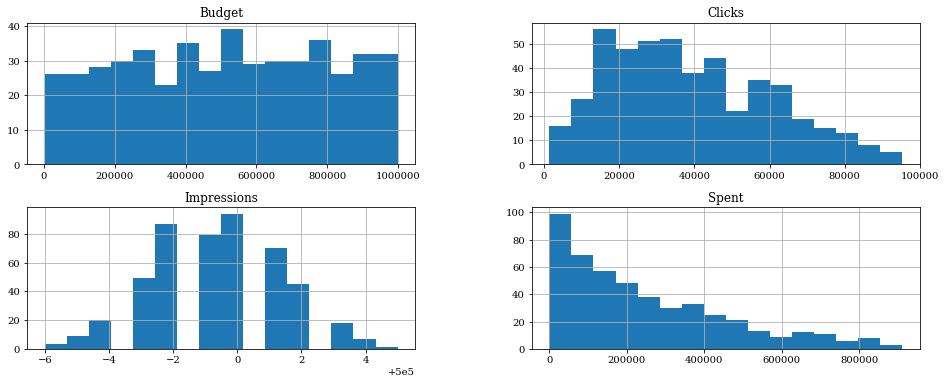

In [51]:
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(bins=16, figsize=(16, 6));

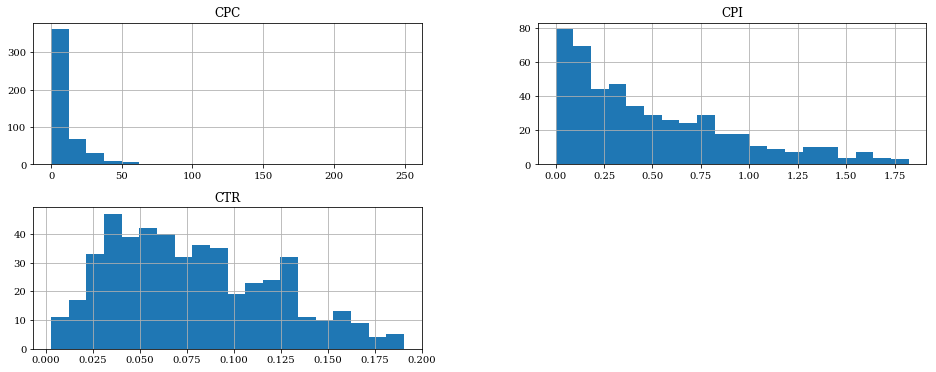

In [52]:
df[['CTR', 'CPC', 'CPI']].hist(bins=20, figsize=(16, 6));

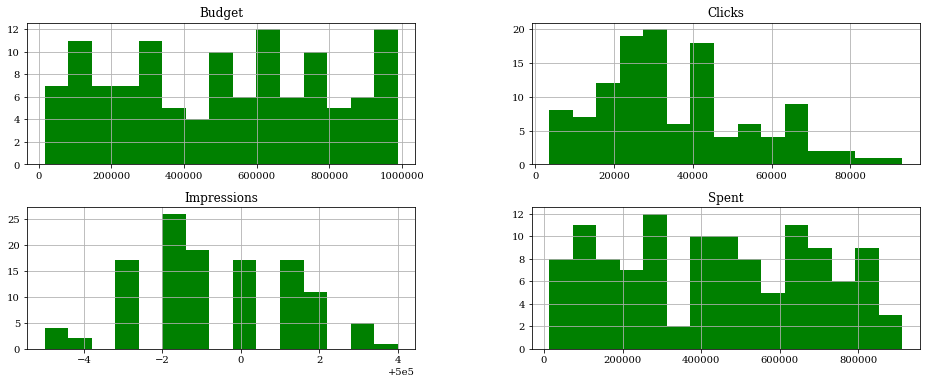

In [53]:
mask = (df.Spent > 0.75 * df.Budget)
df[mask][['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=15, figsize=(16, 6), color='g');

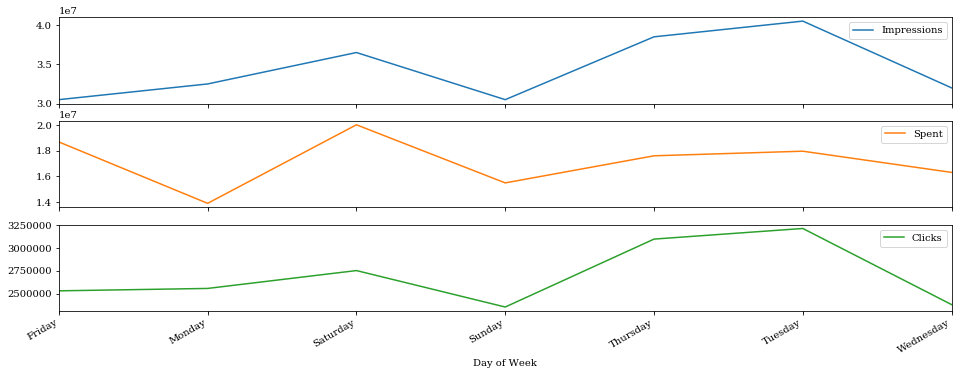

In [54]:
df_weekday = df.groupby(['Day of Week']).sum()
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(figsize=(16, 6), subplots=True);

In [55]:
agg_config = {
    'Impressions': {
        'Mean Impr': 'mean',
        'Std Impr': 'std',
    },
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

Impressions                    Spent  \
                              Mean Impr  Std Impr           mean   
Target Gender Target Age                                           
B             20-25       500000.600000  1.816590  166459.000000   
              20-30       499998.500000  2.725541  272234.125000   
              20-35       500000.000000  1.825742  254239.857143   
              20-40       499999.625000  1.302470  348631.500000   
              20-45       499999.000000       NaN  115459.000000   
              25-30       500001.000000  2.160247  292301.000000   
              25-35       499999.777778  2.682246  218612.888889   
              25-40       499998.900000  1.595131  334988.800000   
              25-45       499998.444444  2.242271  179696.444444   
              25-50       499999.000000       NaN  118388.000000   
              30-35       499999.000000  1.000000  296692.333333   
              30-40       500000.000000  1.511858  114908.625000   
              30-45       500000.500000  0.577350  371586.500000   
              30-50       499999.833333  2.136976  287667.500000   
              30-55       499999.000000  1.000000  454365.666667   
              35-40       500000.750000  2.061553  264739.000000   
              35-45       499999.375000  1.995531  162435.000000   
              35-50       499999.125000  1.885092  276935.375000   
              35-55       500000.125000  2.587746  284749.250000   
              35-60       500003.000000       NaN  260765.000000   
              40-45       500001.166667  1.169045  201948.333333   
              40-50       499999.714286  1.603567  185304.571429   
              40-55       500000.500000  1.378405  135301.500000   
              40-60       499998.571429  2.225395  283024.142857   
              40-65       500000.000000  0.000000   42697.000000   
              45-50       499998.666667  2.516611  355001.666667   
              45-55       500000.500000  0.707107  211940.500000   
              45-60       500000.250000  1.707825  178482.250000   
              45-65       499997.000000       NaN  435961.000000   
F             20-25       499999.750000  2.251983  154226.750000   
...                                 ...       ...            ...   
              45-50       500000.000000       NaN   58120.000000   
              45-55       499999.500000  2.380476  295845.750000   
              45-60       499998.000000       NaN  393196.000000   
              45-65       500000.000000  0.000000  122069.000000   
M             20-25       499998.400000  1.816590  349326.000000   
              20-30       499999.454545  2.161649  359401.727273   
              20-35       499998.600000  2.118700  294380.200000   
              20-40       499998.285714  1.704336  216291.857143   
              25-30       499999.666667  2.250926  294854.000000   
              25-35       499999.062500  1.982213  295026.437500   
              25-40       499998.375000  1.922610  285945.875000   
              25-45       500000.125000  1.959410  374671.875000   
              25-50       500001.500000  0.707107  361446.000000   
              30-35       499999.125000  1.807722  177914.625000   
              30-40       500000.000000  1.000000  428555.333333   
              30-45       500000.375000  2.615203  215427.250000   
              30-50       499999.500000  1.290994  299554.000000   
              30-55       499999.500000  2.121320  116681.500000   
              35-40       499999.166667  2.401388  157767.333333   
              35-45       499998.500000  1.643168  204292.833333   
              35-50       499999.400000  2.073644  269730.200000   
              35-55       499998.750000  2.052873  122788.000000   
              35-60       499998.333333  2.081666   70064.333333   
              40-45       500000.125000  1.457738  143048.500000   
              40-50       499999.250000  2.598076  330665.750000   
              40

In [56]:
pivot = df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)
pivot

Clicks                     Impressions                        \
Target Gender         B         F         M           B          F          M   
Target Age                                                                      
20-25          230899.0  255914.0  238348.0   2500003.0  3999998.0  2499992.0   
20-30          314208.0  202006.0  374423.0   3999988.0  2500000.0  5499994.0   
20-35          291720.0  292055.0  316987.0   3500000.0  3500005.0  4999986.0   
20-40          278910.0  249955.0  113179.0   3999997.0  3999993.0  3499988.0   
20-45           33282.0   22010.0       NaN    499999.0   499998.0        NaN   
25-30          238149.0  395688.0  205716.0   2000004.0  4500003.0  2999998.0   
25-35          383010.0  117768.0  495126.0   4499998.0  1999992.0  7999985.0   
25-40          446850.0  242949.0  272083.0   4999989.0  2499998.0  3999987.0   
25-45          366889.0  217587.0  291406.0   4499986.0  3999997.0  4000001.0   
25-50           71244.0   86286.0   73599.0    499999.0  1500000.0  1000003.0   
30-35           92245.0  434635.0  259247.0   1499997.0  3999992.0  3999993.0   
30-40          287115.0  459152.0   87175.0   4000000.0  3999991.0  1500000.0   
30-45          146076.0  430838.0  277456.0   2000002.0  5500000.0  4000003.0   
30-50          266386.0  112065.0  128615.0   2999999.0  1999997.0  1999998.0   
30-55          151855.0   60595.0  106633.0   1499997.0   500000.0   999999.0   
35-40          182821.0  518831.0  194366.0   2000003.0  6499978.0  2999995.0   
35-45          309941.0  390614.0  207238.0   3999995.0  4999994.0  2999991.0   
35-50          340118.0   65831.0  274496.0   3999993.0   499998.0  2499997.0   
35-55          344712.0  348293.0  236424.0   4000001.0  4499999.0  3999990.0   
35-60           35279.0  156123.0  119627.0    500003.0  1499996.0  1499995.0   
40-45          289835.0  242895.0  331152.0   3000007.0  3500005.0  4000001.0   
40-50          257663.0  124842.0  412817.0   3499998.0  2000001.0  5999991.0   
40-55          309858.0  366672.0  144563.0   3000003.0  4999983.0  1999987.0   
40-60          284193.0  304470.0  528531.0   3499990.0  3999985.0  4999994.0   
40-65           36486.0   52270.0   18415.0   1000000.0   499998.0   500001.0   
45-50           91564.0   75576.0       NaN   1499996.0   500000.0        NaN   
45-55           94247.0  232688.0  114122.0   1000001.0  1999998.0  1499993.0   
45-60          185801.0   58082.0       NaN   2000001.0   499998.0        NaN   
45-65           14947.0  123807.0   48925.0    499997.0  1000000.0   499999.0   

                   Spent                        
Target Gender          B          F          M  
Target Age                                      
20-25           832295.0  1233814.0  1746630.0  
20-30          2177873.0   904513.0  3953419.0  
20-35          1779679.0  2235152.0  2943802.0  
20-40          2789052.0  1174689.0  1514043.0  
20-45           115459.0    95985.0        NaN  
25-30          1169204.0  1841266.0  1769124.0  
25-35          1967516.0  1026763.0  4720423.0  
25-40          3349888.0  1521046.0  2287567.0  
25-45          1617268.0  2345981.0  2997375.0  
25-50           118388.0  1108121.0   722892.0  
30-35           890077.0  1773592.0  1423317.0  
30-40           919269.0  1158873.0  1285666.0  
30-45          1486346.0  2264480.0  1723418.0  
30-50          1726005.0  1669679.0  1198216.0  
30-55          1363097.0    89055.0   233363.0  
35-40          1058956.0  2291978.0   946604.0  
35-45          1299480.0  2195752.0  1225757.0  
35-50          2215483.0   514181.0  1348651.0  
35-55          2277994.0  2814535.0   982304.0  
35-60           260765.0  1173787.0   210193.0  
40-45          1211690.0  1842917.0  1144388.0  
40-50          1297132.0  1510994.0  3967989.0  
40-55           811809.0  2677547.0  2248798.0  
40-60          1981169.0  2582639.0  1013390.0  
40-65            85394.0   180537.0    99912.0  
45-50          1065005.0    58120.0        NaN  
45-